# Individual identification using dimensionality reduction and correlations

## License
This file is part of the project megFingerprinting. All of megFingerprinting code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. megFingerprinting is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with megFingerprinting. If not, see https://www.gnu.org/licenses/.

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import seaborn as sns
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
sns.set()

### Wrangle dataset into two big matrices: a testing matrix and a validation matrix

In [136]:
def prune_subject_csv(filename):
    '''
    This function takes in the subject's csv file from MATLAB, takes out auto-correlations, 
    doubled correlations (because of symmetry) and outputs a numpy array ready to be concatenated
    in the grand feature matrix
    Args:
        filename (string): Name of the csv matrix
    Returns: 
        sub_feat (np.array): Subject's features 
    '''
    freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
    sub_feat = np.zeros([1, int(((67 * 68)/2)*6+1)]) # Number of unique values in corr matrix + subject label
    x = 0
    for iFreq in freq_band:
        aec_matrix = pd.read_csv(filename, names = ['source', 'target', 'corr', 'freq_band'])
        aec_matrix = aec_matrix.loc[aec_matrix['freq_band'] == iFreq]
        aec_matrix = aec_matrix.replace('\s', '', regex = True).pivot_table(index = 'source', columns = 'target', values = 'corr') 
        df_out = aec_matrix.stack()
        df_out = df_out[df_out.index.get_level_values(0) != df_out.index.get_level_values(1)]
        df_out = df_out[df_out.index.get_level_values(0) < df_out.index.get_level_values(1)]
        df_out.index = df_out.index.map('_'.join)
        sub_feat[0, x*2278 : ((x+1)*2278)] = df_out.to_frame().T.values
        x += 1
    sub_feat[0, -1] = int(filename[25:28])    
    return sub_feat

# Get 20 subjects: both training and testing datasets
onlyfiles = [f for f in listdir('output/csv_matrices/') if isfile(join('output/csv_matrices/', f))]
n_subs = 50 # Change here to get number of participants! \
sub_train = np.zeros([n_subs, int(((67 * 68)/2)*6+1)])
sub_valid = np.zeros([n_subs, int(((67 * 68)/2)*6+1)])
iv = 0
it = 0
for iFile in sorted(onlyfiles)[0:(n_subs*2)]: 
    sub = 'output/csv_matrices/' + iFile
    if sub[39] == 'v':
        sub_valid[iv, :] = prune_subject_csv(sub)
        iv += 1
    else:
        sub_train[it, :] = prune_subject_csv(sub)
        it += 1

### Use PCA to reduce each frequency band connectome to two features 

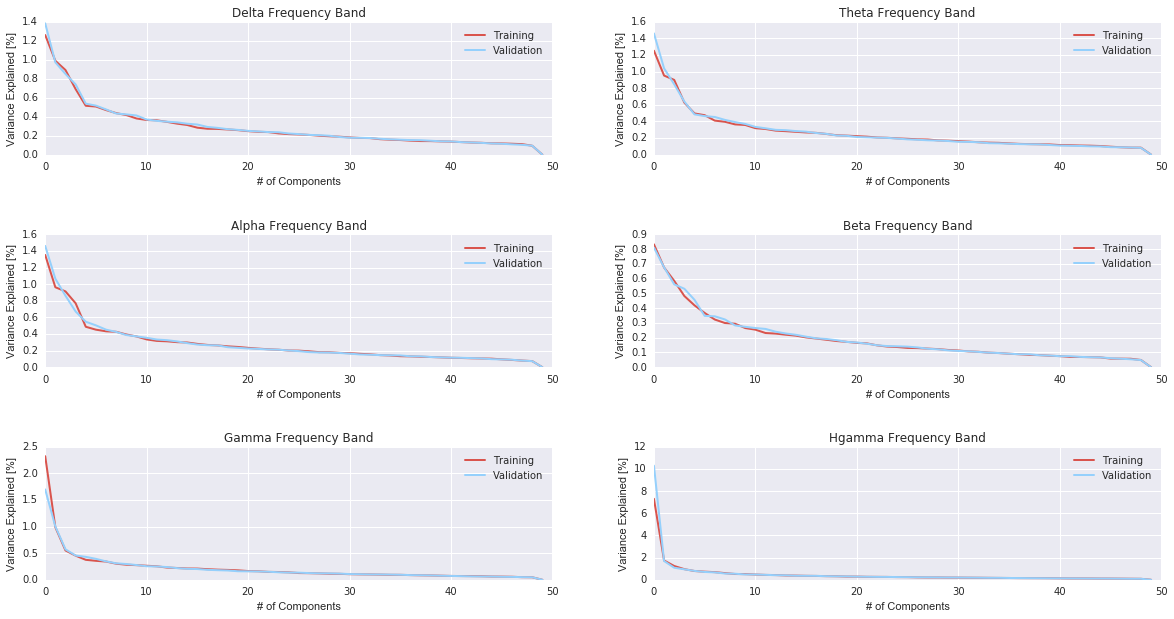

In [142]:
freq_band = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Hgamma']
fig, axs = plt.subplots(3,2, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace= .2)
n_pc = 4
axs = axs.ravel()
sub_train_pca = np.zeros([n_subs, n_pc*6])
sub_valid_pca = np.zeros([n_subs, n_pc*6])

for i in range(len(freq_band)):
    # PCA on a given frequency band training set
    pca = PCA()
    pca.fit(sub_train[:, (2278*i):(2278*(i+1))])
    sub_train_pca[:, (i*n_pc):((i+1)*n_pc)] = pca.transform(sub_train[:, (2278*i):(2278*(i+1))])[:, :n_pc]
    
    # Plot variance explained per frequency band
    axs[i].plot(pca.explained_variance_, linewidth=2, label = 'Training', color =sns.xkcd_rgb["pale red"])
    axs[i].set_xlabel('# of Components')
    axs[i].set_ylabel('Variance Explained [%]')
    axs[i].set_title(freq_band[i] + ' Frequency Band')
    
    # PCA on a given frequency band validation set
    pca = PCA()
    pca.fit(sub_valid[:, (2278*i):(2278*(i+1))])
    sub_valid_pca[:, (i*n_pc):((i+1)*n_pc)] = pca.transform(sub_valid[:, (2278*i):(2278*(i+1))])[:, :n_pc]
    
    # Plot variance explained per frequency band
    axs[i].plot(pca.explained_variance_, linewidth=2, label = 'Validation', color = sns.xkcd_rgb["light blue"])
    axs[i].legend()

plt.show()

### Build classifier using correlations

In [143]:
predictions = np.zeros([len(sub_valid_pca), len(sub_train_pca)])
sign = np.zeros([len(sub_valid_pca), len(sub_train_pca)])
for iv in range(len(sub_valid_pca)): 
    for it in range(len(sub_train_pca)):
        predictions[iv, it] = sp.stats.pearsonr(sub_valid_pca[iv, :], sub_train_pca[it,:])[0]
        sign[iv, it] = sp.stats.pearsonr(sub_valid_pca[iv, :], sub_train_pca[it,:])[1]
accuracy_score(range(n_subs), predictions.argmax(axis = 1))

0.62